In [110]:
import matplotlib.pyplot as plt
import numpy as np

In [111]:
def batch_normalization(X, epsilon=1e-8):
    mean = np.mean(X, axis=0)
    variance = np.var(X, axis=0)
    return (X - mean) / np.sqrt(variance + epsilon)


X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
X_normalized = batch_normalization(X)
print(X_normalized)

[[-1.22474487 -1.22474487 -1.22474487]
 [ 0.          0.          0.        ]
 [ 1.22474487  1.22474487  1.22474487]]


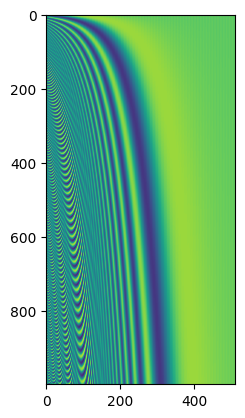

In [112]:

def position_encoding(seq_length, d=512, n=10000):
    p = np.zeros((seq_length, d))
    for k in range(seq_length):
        for i in np.arange(int(d/2)):
            denom = n**(2*i/d)
            p[k, 2*i] = np.sin(k/denom)
            p[k, 2*i+1] = np.cos(k/denom)
    return p


x = np.arange(100)
p = position_encoding(seq_length=1000, d=512)
plt.imshow(p)
plt.show()

# Object Detection Metrics/Losses

IoU is calculated as the area of overlap between the two bounding boxes divided by the area of their union. It's a simple and effective metric, but it has a limitation: it doesn't take into account the relative positions of the boxes when they don't overlap. This means that two pairs of boxes can have the same IoU even if one pair is better aligned than the other. IoU ranges from 0 to 1, where 0 means no overlap and 1 means perfect overlap. However, IoU is not differentiable at 0, which makes it unsuitable for use as a loss function in a learning algorithm.

GIoU extends IoU by also considering the area of the smallest enclosing box that contains both boxes. Specifically, it subtracts from the IoU a term that represents the ratio of the area outside the union but inside the enclosing box to the area of the enclosing box. This makes GIoU a more comprehensive metric that can distinguish between different relative positions of the boxes. GIoU is differentiable and can be used as a loss function.


$$ IoU = \frac{b_1 \cap b_2}{b_1 \cup b_2} $$

$$ GIoU = IoU- \frac{C - (b_1 \cup b_2)}{C} $$

$$ DIoU = IoU - \frac{d^2}{c^2} $$

$$ CIoU = IoU - \frac{d^2 + \rho^2}{c^2} $$

* $C$ is the area of the smallest enclosing box that contains both bounding boxes.
* $d$ is the Euclidean distance between the central points of the two bounding boxes.
* $c$ is the diagonal length of the smallest enclosing box that contains both bounding boxes.
* $\rho$ is the difference in aspect ratio between the two bounding boxes.

In [113]:
def center_distance(box1, box2):
    x1 = (box1[0] + box1[2]) / 2
    y1 = (box1[1] + box1[3]) / 2
    x2 = (box2[0] + box2[2]) / 2
    y2 = (box2[1] + box2[3]) / 2
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def center_of_box(box):
    x = (box[0] + box[2]) / 2
    y = (box[1] + box[3]) / 2
    return x, y

def intersection_boxes(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    area = max(0, x2 - x1) * max(0, y2 - y1)
    if area == 0:
        return (0, 0, 0, 0), 0
    return (x1, y1, x2, y2), area

def union_boxes(box1, box2):
    intersection, intersection_area = intersection_boxes(box1, box2)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area
    return union_area

def diagonal_boxes(box1, box2):
    start_coordinates = (box1[0], box1[1])
    end_coordinates = (box2[2], box2[3])
    length = np.sqrt((end_coordinates[0] - start_coordinates[0])**2 + (end_coordinates[1] - start_coordinates[1])**2)
    return length, start_coordinates, end_coordinates

def enclosing_box(box1, box2):
    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])
    x2 = max(box1[2], box2[2])
    y2 = max(box1[3], box2[3])
    area = (x2 - x1) * (y2 - y1)
    return (x1, y1, x2, y2), area


In [114]:
def iou(box1, box2):
    _, isec_area = intersection_boxes(box1, box2)
    union_area = union_boxes(box1, box2)
    return isec_area / union_area

def giou(box1, box2):
    _iou = iou(box1, box2)
    enc, enc_area = enclosing_box(box1, box2)
    isec, isec_area = intersection_boxes(box1, box2)
    union_area = union_boxes(box1, box2)
    return  _iou - (enc_area - union_area) / enc_area

def diou(box1, box2):
    _iou = iou(box1, box2)
    dist = center_distance(box1, box2)
    diag_legnth, _, _ = diagonal_boxes(box1, box2)
    return _iou - dist**2 / diag_legnth**2

In [122]:

def plot_boxes(box1, box2):
    isec, isec_area = intersection_boxes(box1, box2)
    union_area = union_boxes(box1, box2)
    enc, enc_area = enclosing_box(box1, box2)
    dist = center_distance(box1, box2)
    c1 = center_of_box(box1)
    c2 = center_of_box(box2)

    diag_length, diag_start, diag_end = diagonal_boxes(box1, box2)

    print("Intersection Area:", isec_area)
    print("Union Area:", union_area)
    print("Enclosing Area:", enc_area)
    print("Center Distance:", dist)
    print("Center 1:", c1)
    print("Center 2:", c2)
    print("Diagonal Length:", diag_length)

    plt.xlim(0, 110)
    plt.ylim(0, 110)
    plt.plot([box1[0], box1[2], box1[2], box1[0], box1[0]], [box1[1], box1[1], box1[3], box1[3], box1[1]], color='r')
    plt.plot([box2[0], box2[2], box2[2], box2[0], box2[0]], [box2[1], box2[1], box2[3], box2[3], box2[1]], color='b')
    plt.plot([isec[0], isec[2], isec[2], isec[0], isec[0]], [isec[1], isec[1], isec[3], isec[3], isec[1]], color='g')
    plt.plot([enc[0], enc[2], enc[2], enc[0], enc[0]], [enc[1], enc[1], enc[3], enc[3], enc[1]], color='y')
    plt.plot([diag_start[0], diag_end[0]], [diag_start[1], diag_end[1]], color='k', linestyle='dotted', linewidth=0.1)

    print("IoU:", iou(box1, box2))
    print("GIoU:", giou(box1, box2))
    print("DIoU:", diou(box1, box2))

Intersection Area: 900
Union Area: 2300
Enclosing Area: 2500
Center Distance: 14.142135623730951
Center 1: (30.0, 30.0)
Center 2: (40.0, 40.0)
Diagonal Length: 70.71067811865476
IoU: 0.391304347826087
GIoU: 0.31130434782608696
DIoU: 0.351304347826087


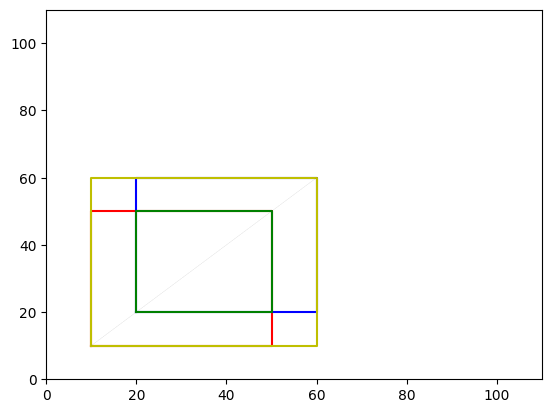

In [123]:
box1 = np.array([10, 10, 50, 50])
box2 = np.array([20, 20, 60, 60])
plot_boxes(box1, box2)

Intersection Area: 0
Union Area: 3200
Enclosing Area: 8100
Center Distance: 70.71067811865476
Center 1: (30.0, 30.0)
Center 2: (80.0, 80.0)
Diagonal Length: 127.27922061357856
IoU: 0.0
GIoU: -0.6049382716049383
DIoU: -0.30864197530864196


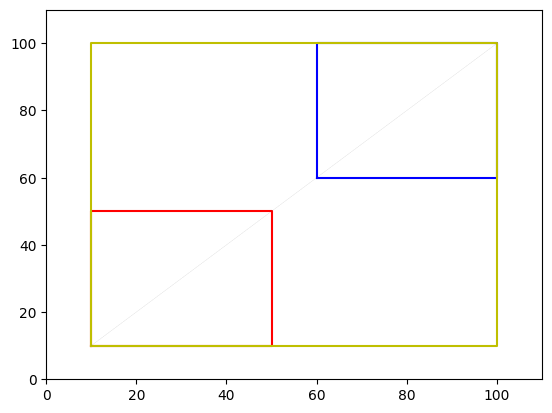

In [124]:
box1 = np.array([10, 10, 50, 50])
box2 = np.array([60, 60, 100, 100])
plot_boxes(box1, box2)
# iou is 0 because the boxes do not intersect
# giou is negative because the boxes do not intersect
# diou is negative because the boxes do not intersect
